In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
raw = np.loadtxt('planet1_rv.txt')
jd, rv, e = raw[:, 0], raw[:, 1], raw[:, 2]

In [3]:
from astropy.timeseries import LombScargle
import astropy.units as u

<ErrorbarContainer object of 3 artists>

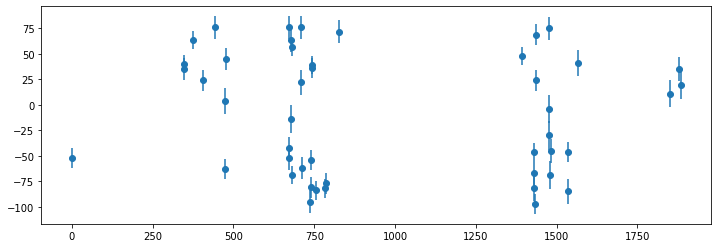

In [9]:
f, ax = plt.subplots(figsize=(12, 4))
ax.errorbar(jd - jd[0], rv, yerr=e, fmt = 'o')

3.524728736853994


<ErrorbarContainer object of 3 artists>

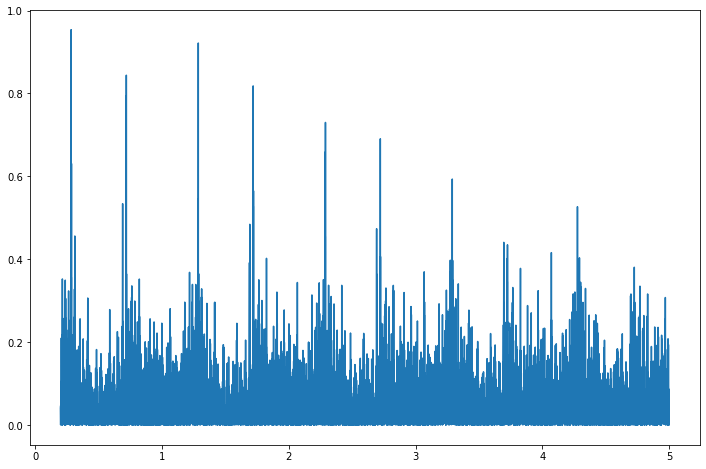

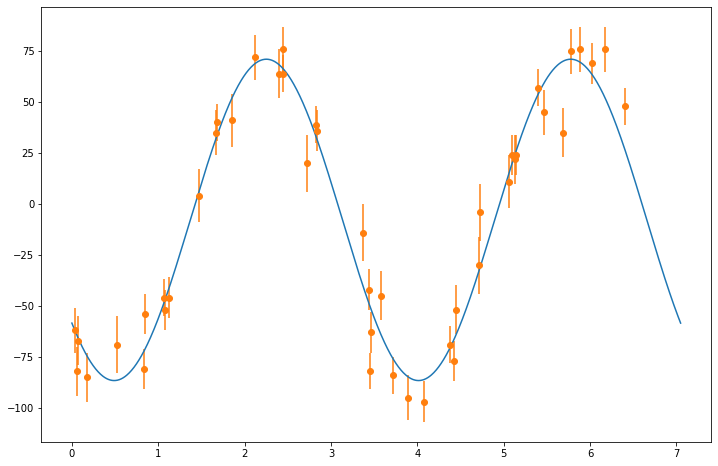

In [5]:
fre, power = LombScargle(jd, rv, dy=e).autopower(minimum_frequency=0.2,
                                           maximum_frequency=5,
                                           samples_per_peak=1000)
plt.figure(figsize=(12, 8))
plt.plot(fre, power)
best_frequency = fre[power.argmax()]
print(1/best_frequency)
LS = LombScargle(jd, rv, fit_mean=True)
t_fit = np.linspace(0, 1 / best_frequency * 2, 1000)
y_fit = LS.model(t_fit, best_frequency)
plt.figure(figsize=(12, 8))
plt.plot(t_fit, y_fit)
plt.errorbar((jd) % (1 / best_frequency * 2), rv, yerr=e, fmt='o')

# RV 拟合

$$
RV(t)=v\sin(\omega t+\phi_0)+v_0=v\sin\omega t\cos\phi_0+v\cos\omega t\sin\phi_0+v_0
$$

其中的 $\omega$ 与初相位 $\phi_0$ 耦合在一起，无法同时通过线性回归得到

为此，我们固定 $\omega$，用线性回归估计 $\phi_0$ 和 $v_0$，进而在参数空间 $(v,\omega)$ 中寻找残差最小的点，作为 $v$ 和 $\omega$ 的估计

首先考虑线性模型

$$
Y=K_1X_1+K_2X_2+K_0
$$

我们已经获取了 $n$ 组数据，$(x_{1,i}, x_{2,i}, y_i),\ i=1,2,\cdot,n$，希望选取 $K_1,K_2,K_0$ 使得残差平方和

$$
\sum_{i=1}^n(K_1x_{1,i}+K_2x_{2,i}+K_0-y_i)^2
$$

最小，则必有该残差平方和相对 $K_0,K_1,K_2$ 的偏导数各自为零，即

$$
\left\{
\begin{array}{cc}
\sum_{i=1}^n(K_1x_{1,i}+K_2x_{2,i}+K_0-y_i)x_{1,i}=0\\
\sum_{i=1}^n(K_1x_{1,i}+K_2x_{2,i}+K_0-y_i)x_{2,i}=0\\
\sum_{i=1}^n(K_1x_{1,i}+K_2x_{2,i}+K_0-y_i)=0\\
\end{array}
\right.
$$

记

$$
\sum_{i=1}^nx_{1,i}=X_{1},\quad \sum_{i=1}^nx_{2,i}=X_{2},\quad \sum_{i=1}^ny_{i}=Y
$$

$$
\sum_{i=1}^nx_{1,i}^2=XX_{11},\quad \sum_{i=1}^nx_{2,i}^2=XX_{22},\quad \sum_{i=1}^nx_{1,i}x_{2,i}=XX_{12}
$$

$$
\sum_{i=1}^ny_ix_{1,i}=YX_{1},\quad \sum_{i=1}^ny_ix_{2,i}=YX_{2}
$$

则方程组简化为

$$
\left\{
\begin{array}{c}
K_1XX_{11}+K_2XX_{12}+K_0X_1-YX_1=0\\
K_1XX_{12}+K_2XX_{22}+K_0X_2-YX_2=0\\
K_1X_1+K_2X_2+nK_0-Y=0\\
\end{array}
\right.
\Leftrightarrow 
\left(
\begin{array}{ccc}
XX_{11} & XX_{12} & X_1\\
XX_{12} & XX_{22} & X_2\\
X_{1} & X_{2} & n\\
\end{array}
\right)
\left(
\begin{array}{c}
K_1\\K_2\\K_0
\end{array}
\right)
=
\left(
\begin{array}{c}
YX_1\\YX_2\\Y
\end{array}
\right)
$$

可以解得

$$
\left(
\begin{array}{c}
K_1\\K_2\\K_0
\end{array}
\right)
=
\left(
\begin{array}{ccc}
XX_{11} & XX_{12} & X_1\\
XX_{12} & XX_{22} & X_2\\
X_{1} & X_{2} & n\\
\end{array}
\right)^{-1}
\left(
\begin{array}{c}
YX_1\\YX_2\\Y
\end{array}
\right)
$$

进而计算残差平方和

在我们的模型中，

$$
x_{1,i}=\sin(\omega t_i),\quad x_{2,i}=\cos(\omega t_i)
$$

$$
K_0=v_0, \quad K_1=v\cos\phi_0, \quad K_2=v\sin\phi_0
$$

$$
y_{i}=RV(t_i)
$$

据此进行回归运算

In [77]:
def least_square(jd, rv, pmin=0.2, pmax=5, bins=10000):
    omega_temp = 2 * np.pi / np.linspace(pmin, pmax, bins)
    omega_t = np.array([])
    K1_t, K2_t, K0_t = np.array([]), np.array([]), np.array([])
    res_t = np.array([])
    for omega in omega_temp:
        x1 = np.sin(omega * jd)
        x2 = np.cos(omega * jd)
        y = rv

        XX11 = (x1**2).sum()
        XX12 = (x1 * x2).sum()
        XX22 = (x2**2).sum()
        X1 = x1.sum()
        X2 = x2.sum()
        YX1 = (y * x1).sum()
        YX2 = (y * x2).sum()
        Y = y.sum()

        MatX = np.matrix([[XX11, XX12, X1], [XX12, XX22, X2],
                          [X1, X2, len(jd)]])
        MatY = np.matrix([[YX1], [YX2], [Y]])
        MatK = MatX**(-1) * MatY

        K1, K2, K0 = float(MatK[0]), float(MatK[1]), float(MatK[2])

        res = ((K1 * x1 + K2 * x2 + K0 - y)**2).sum()

        omega_t = np.append(omega_t, omega)
        K1_t, K2_t, K0_t = np.append(K1_t,
                                     K1), np.append(K2_t,
                                                    K2), np.append(K0_t, K0)
        res_t = np.append(res_t, res)

    return (omega_t, K1_t, K2_t, K0_t, res_t)

In [78]:
omega_t, K1_t, K2_t, K0_t, res_t = least_square(jd=jd, rv=rv)

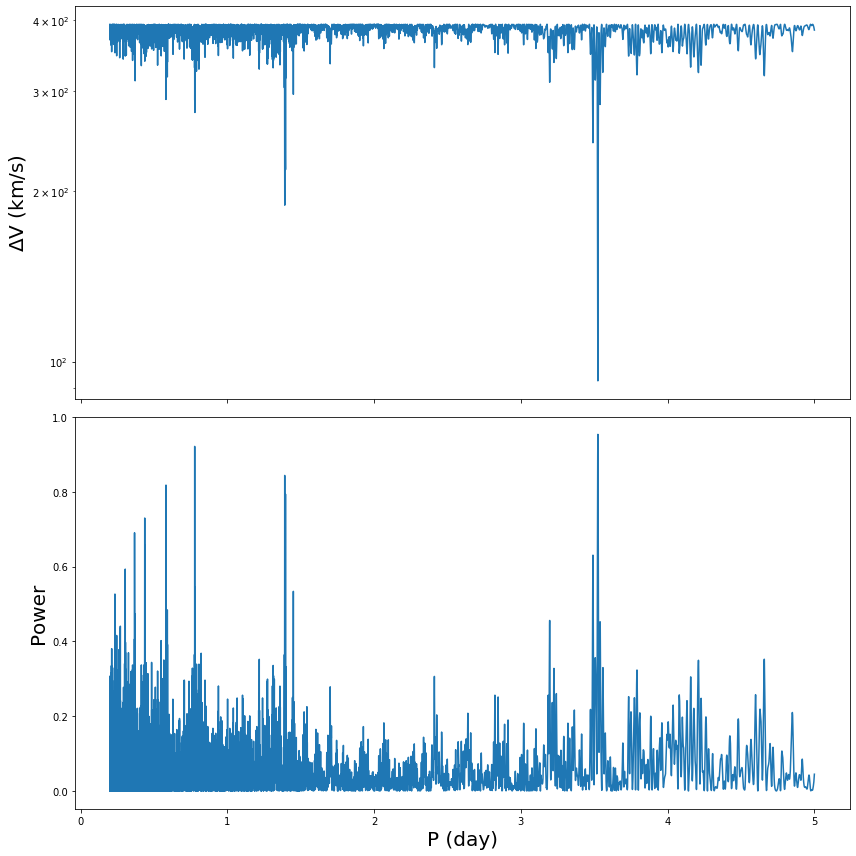

In [52]:
f, ax = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

ax[1].set_xlabel('P (day)', fontsize=20)
ax[0].set_ylabel('$\Delta$V (km/s)', fontsize=20)
ax[1].set_ylabel('Power', fontsize=20)
ax[0].set_yscale('log')

ax[0].plot((2 * np.pi) / omega_t, np.sqrt(res_t))
ax[1].plot(1 / fre, power)

f.tight_layout()

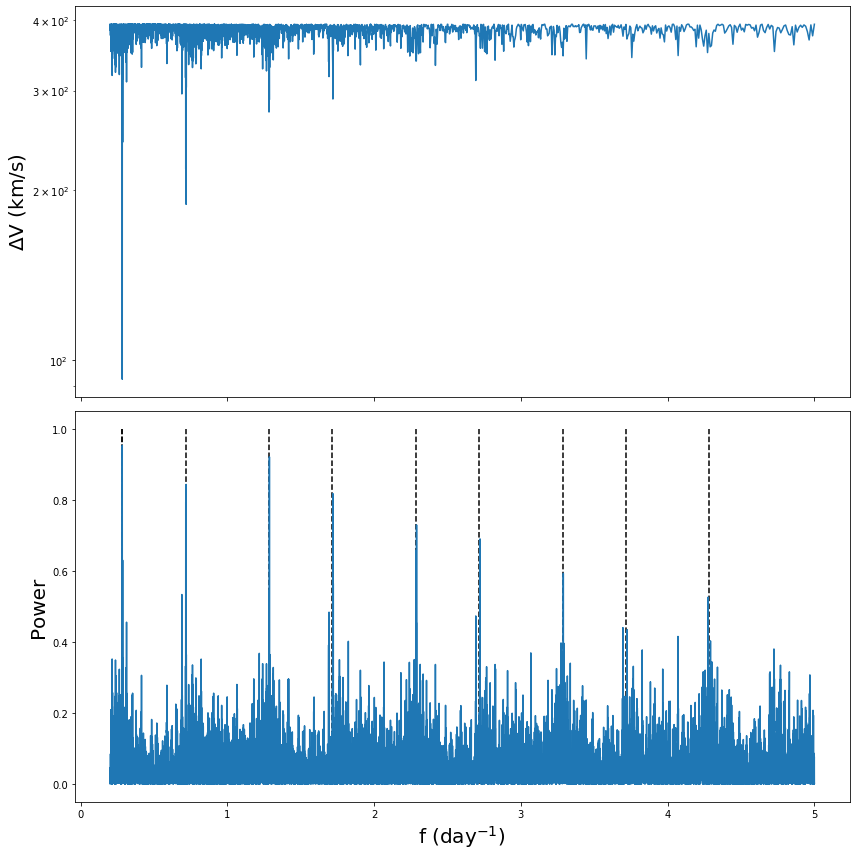

In [53]:
f, ax = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

ax[1].set_xlabel('f (day$^{-1}$)', fontsize=20)
ax[0].set_ylabel('$\Delta$V (km/s)', fontsize=20)
ax[1].set_ylabel('Power', fontsize=20)
ax[0].set_yscale('log')

ax[0].plot(omega_t / (2 * np.pi), np.sqrt(res_t))

ax[1].plot(fre, power)
for i in range(5):
    ax[1].vlines(best_frequency + i, 0, 1, linestyle='--')
    ax[1].vlines(abs(-best_frequency + i), 0, 1, linestyle='--')

f.tight_layout()

In [81]:
omega_t, K1_t, K2_t, K0_t, res_t = least_square(jd, rv, pmin=3.51, pmax=3.54, bins=1000)

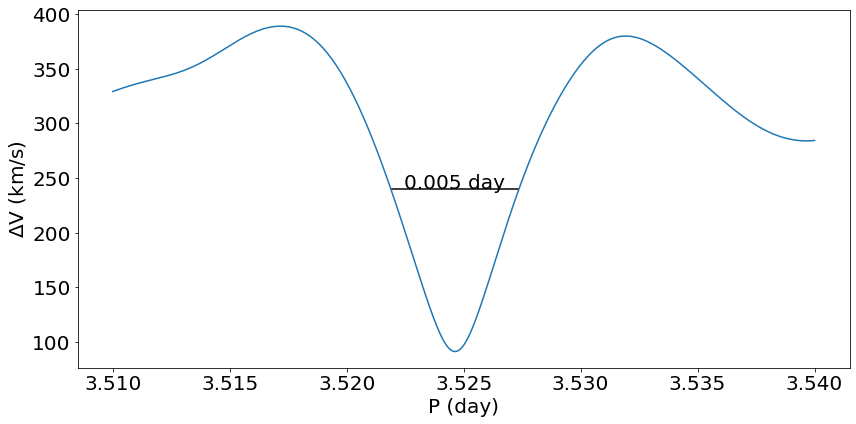

In [96]:
f, ax = plt.subplots(figsize=(12, 6), sharex=True)

ax.set_xlabel('P (day)', fontsize=20)
ax.set_ylabel('$\Delta$V (km/s)', fontsize=20)

#ax.set_yscale('log')

P = (2 * np.pi)/omega_t
r = np.sqrt(res_t)
args = np.argwhere(r < (r.min() + r.max()) / 2).flatten()

ax.plot(P, r)
ax.hlines((r.min() + r.max()) / 2, P[args].min(), P[args].max())
ax.text(P[args].mean(), (r.min() + r.max()) / 2, '0.005 day', size=20, horizontalalignment='center')
ax.tick_params(labelsize=20)

f.tight_layout()
FWHM_dv = P[args].max()-P[args].min()

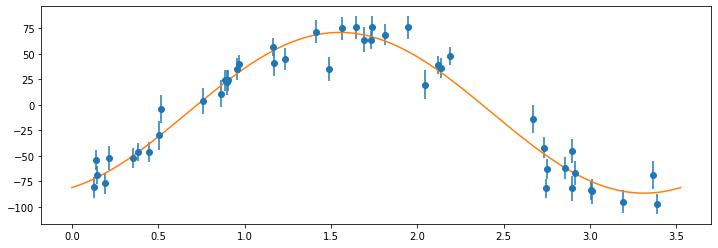

In [58]:
arg = res_t.argmin()
om = omega_t[arg]
v = np.sqrt(K1_t[arg]**2 + K2_t[arg]**2)
phi = np.arctan2(K2_t[arg], K1_t[arg])
v0 = K0_t[arg]
def pred(t):
    return (v * np.sin(om * t + phi) + v0)

P = 2 * np.pi / omega_t[arg]
f, ax = plt.subplots(figsize=(12, 4))

ax.errorbar(jd % P, rv, yerr=e, fmt='o')
t = np.linspace(0, P, 1000)
ax.plot(t, pred(t))

In [59]:
K0_t[arg], P

(-7.754938676904485, 3.5246334633463348)